# FFNN Model

In this part, as a beginner of neural network, I studied the feedforward neural network built with **TensorFlow**. Feedforward neural network is one of the simplest and most commonly used neural networks. Deep feedforward neural network is also called multi-layer perceptron. Its purpose is to realize the mapping of input to output, which is essentially a compound function.

EDA and data preprocessing have been implemented in the last notebook, and this notebook will be divided into the following parts:

1. Review the data

2. Model building

3. Hyperparameter learning and optimization

4. Prediction

5. Tensorflow, HPC and more

6. References

In this assessment, some computations were done in the HPC. The corresponding "py" files and "log" files are in the "[data](https://github.com/xiaozhang-github/DST-Assessment-4/tree/main/Data)" folder. These codes would not run on the local laptop.

In [2]:
import numpy as np
from numpy import argmax
import pandas as pd
import csv
import pickle
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras import losses
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
np.random.seed(2021)

## 1. Review the data

After the preprocessing in the last notebook, we generated the "CSV" files of the training set and test set. In order to save space and facilitate uploading, we compressed them into the "ZIP" files and placed them in the "[data](https://github.com/xiaozhang-github/DST-Assessment-4/tree/main/Data)" folder.

In [3]:
train = pd.read_csv("https://github.com/xiaozhang-github/DST-Assessment-4/raw/main/Data/CICIDS2017_Wed_train.zip",header=None)
test = pd.read_csv("https://github.com/xiaozhang-github/DST-Assessment-4/raw/main/Data/CICIDS2017_Wed_test.zip",header=None)

In [4]:
train_x = train.drop([78],axis=1)
train_y = train[78]
test_x = test.drop([78],axis=1)
test_y = test[78]

In [5]:
pd.DataFrame(train_x).head(10)

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,-0.356380,1.689182,-0.000763,-0.004297,-0.030008,-0.002422,0.226687,-0.294406,-0.123240,0.179473,...,-0.007170,0.829301,-0.128928,-0.100491,-0.146992,-0.101172,2.040675,-0.105787,2.010981,2.053094
1,-0.356380,1.366990,-0.000763,-0.004297,-0.025145,-0.002422,0.266406,-0.294406,-0.102113,0.213784,...,-0.005773,-1.068350,-0.127498,-0.100491,-0.146077,-0.099516,1.660574,-0.105787,1.634422,1.672530
2,-0.358097,-0.655085,-0.011460,-0.009372,-0.074096,-0.007510,-0.223470,1.642477,0.242973,-0.366976,...,-0.008567,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.571490
3,-0.356380,-0.652197,-0.008786,-0.003282,-0.032439,-0.002422,0.201862,-0.294406,0.367627,0.541233,...,-0.007170,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.571490
4,-0.356380,-0.655086,-0.011460,-0.009372,-0.090143,-0.007591,-0.387314,-0.294406,-0.384520,-0.366976,...,-0.008567,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.571490
5,-0.356380,-0.655631,-0.010123,-0.010387,-0.090143,-0.007591,-0.387314,-0.294406,-0.384520,-0.366976,...,-0.008567,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.571490
6,-0.358097,-0.655627,-0.010123,-0.008357,-0.077176,-0.007541,-0.321114,0.488173,-0.130987,-0.366976,...,-0.007170,-1.068350,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.571490
7,-0.358097,-0.648612,-0.010123,-0.008357,-0.081715,-0.007553,-0.344284,0.214270,-0.219723,-0.366976,...,-0.007170,-1.068350,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.571490
8,-0.358097,-0.655627,-0.010123,-0.008357,-0.077176,-0.007541,-0.321114,0.488173,-0.130987,-0.366976,...,-0.007170,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.571490
9,-0.333292,0.615863,-0.002100,-0.004297,-0.081553,-0.007591,-0.299600,-0.294406,-0.342528,-0.284177,...,-0.007170,0.829301,-0.080638,-0.099378,-0.115225,-0.045762,-0.313326,-0.105664,-0.321088,-0.303783


This dataset has a total of 78 features, all of which are continuous variables, and six labels, including benign traffic and five attacks. Our aim is to build a feedforward neural network classifier to identify attacks and detect intruders.

## 2. Model building
### A simple attempt

We first established a FFNN with two hidden layers [2]. Different from the binary classifier, for the multi-classification problem, we chose "softmax" as the activation function, "sparse_categorical_crossentrop" as the loss function, and the number of label categories as the number of neurons in the output layer [3] [4].

For the number of neurons in the hidden layer, we choose the average number of nodes in the input layer and the output layer. For the optimizer, we choose the advanced "Adam" [1].

In [6]:
model_2h = Sequential()
model_2h.add(Dense(42, input_dim=78, activation='relu'))
model_2h.add(Dense(42, activation='relu'))
model_2h.add(Dense(6, activation='softmax'))
model_2h.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
model_2h.fit(train_x, train_y, epochs=5, batch_size=128)

Epoch 1/5
483984/483984 [==============================] - 5s 11us/step - loss: 0.0587 - accuracy: 0.9816
Epoch 2/5
483984/483984 [==============================] - 5s 11us/step - loss: 0.0274 - accuracy: 0.9904
Epoch 3/5
483984/483984 [==============================] - 5s 11us/step - loss: 0.0249 - accuracy: 0.9911
Epoch 4/5
483984/483984 [==============================] - 5s 10us/step - loss: 0.0232 - accuracy: 0.9915
Epoch 5/5
483984/483984 [==============================] - 5s 10us/step - loss: 0.0220 - accuracy: 0.9922


In [8]:
model_2h.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 42)                3318      
_________________________________________________________________
dense_2 (Dense)              (None, 42)                1806      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 258       
Total params: 5,382
Trainable params: 5,382
Non-trainable params: 0
_________________________________________________________________


## 3. Hyperparameter learning and optimization

We can see that the classifier already has a good accuracy, and our next goal is to improve it through parameter optimization.

For many parameters of neural networks, there is no fixed law or experience, so try to explore and try to understand them.

### Number of epochs

In the example above, we found that the accuracy increased as the epochs increased, and we need to know if it is still true when epochs were large enough. The larger the epochs are, the longer the operation time of the neural network will be, so it can't go infinitely large. We also need to determine an appropriate value to ensure the accuracy without consuming an extremely long time.

The following style of code represents that it would run on the HPC, and this is just the core code in the "py" file.

In [9]:
#model = Sequential()
#model.add(Dense(42, input_dim=78, activation='relu'))
#model.add(Dense(42, activation='relu'))
#model.add(Dense(6, activation='softmax'))
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#epochs=list()
#train_acc=list()
#test_acc=list()
#deltaepochs=1
#eon=0

#for i in range(0,200) :
#        print("epoch : " + str(eon))
#        model.fit(train_x, train_y, epochs=deltaepochs, batch_size=256)
#        scores = model.evaluate(train_x, train_y)
#        test_scores = model.evaluate(test_x, test_y)
#        eon+=deltaepochs
#        epochs.append(eon)
#        train_acc.append(scores[1])
#        test_acc.append(test_scores[1])

#model.save('epochs_model.h5')
#pickle.dump(epochs, open( "epochs.p", "wb" ) )
#pickle.dump(train_acc, open( "epochs_train_acc.p", "wb" ) )
#pickle.dump(test_acc, open( "epochs_test_acc.p", "wb" ) )

In [10]:
epochs_train_acc = pickle.load(open('epochs_train_acc.p','rb'))
epochs_test_acc = pickle.load(open('epochs_test_acc.p','rb'))
epochs = pickle.load(open('epochs.p','rb'))

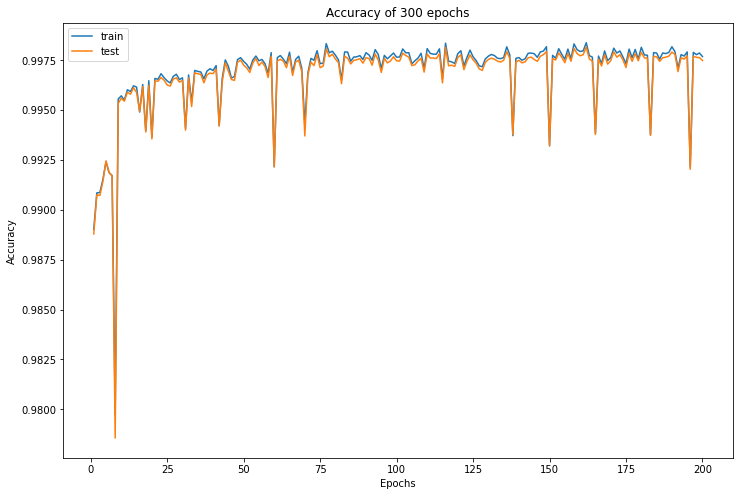

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(epochs, epochs_train_acc, label='train')
plt.plot(epochs, epochs_test_acc,label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of 300 epochs')
plt.legend()

plt.show()

It can be seen that the accuracy is not strictly positive correlated with epochs, but when the epochs is greater than 100, the accuracy can be maintained at a high level except for a few outlier points.

When adjusting FFNN, we need to set large epochs and be aware of the "trap" of outliers.

In [12]:
epochs_model = tf.keras.models.load_model('epochs_model.h5')

In [13]:
epochs_model.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_205 (Dense)            (None, 42)                3318      
_________________________________________________________________
dense_206 (Dense)            (None, 42)                1806      
_________________________________________________________________
dense_207 (Dense)            (None, 6)                 258       
Total params: 5,382
Trainable params: 5,382
Non-trainable params: 0
_________________________________________________________________


### Number of batch_size

Since the computer is binary processing, we should choose batch_size from 2,4,8,16,32,64,128,256, etc. For different fields, data and neural network models, the rules of batch_size are different, some choose a larger value, while others choose 0-32. However, it is certain that when the computing force is limited, it is better to choose a larger batch_size without losing much accuracy [5].

In [14]:
#batch_size=list()
#train_acc=list()
#test_acc=list()
#size=8

#for i in range(0,8) :
#        model = Sequential()
#        model.add(Dense(42, input_dim=78, activation='relu'))
#        model.add(Dense(42, activation='relu'))
#        model.add(Dense(6, activation='softmax'))
#        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#        print("batch_size : " + str(size))
#        model.fit(train_x, train_y, epochs=10, batch_size=size)
#        scores = model.evaluate(train_x, train_y)
#        test_scores = model.evaluate(test_x, test_y)
#        batch_size.append(size)
#        train_acc.append(scores[1])
#        test_acc.append(test_scores[1])
#        size*=2

#pickle.dump(batch_size, open( "batch_size.p", "wb" ) )
#pickle.dump(train_acc, open( "batch_train_acc.p", "wb" ) )
#pickle.dump(test_acc, open( "batch_test_acc.p", "wb" ) )

In [15]:
batch_train_acc = pickle.load(open('batch_train_acc.p','rb'))
batch_test_acc = pickle.load(open('batch_test_acc.p','rb'))
batch_size = pickle.load(open('batch_size.p','rb'))

In [16]:
dic1 = {'batch_size':['8', '16', '32', '64', '128', '256', '512', '1024']
       ,'train_acc':batch_train_acc
       ,'test_acc':batch_test_acc}
pd.DataFrame(dic1)

,batch_size,train_acc,test_acc
0,8,0.994969,0.994682
1,16,0.995789,0.995690
2,32,0.996101,0.995945
3,64,0.995901,0.995796
4,128,0.995578,0.995569
5,256,0.996107,0.995839
6,512,0.995919,0.995786
7,1024,0.991190,0.991148


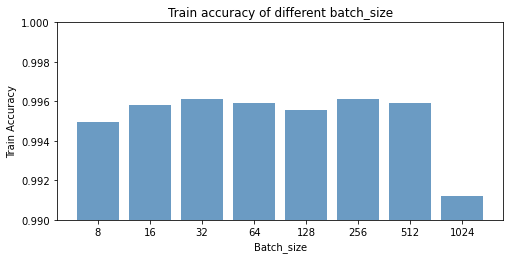

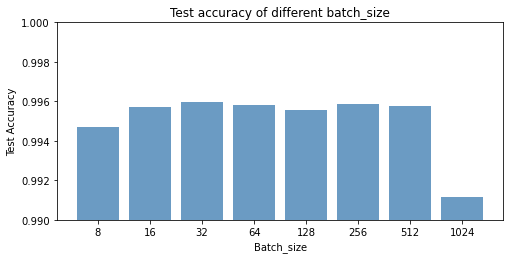

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.bar(range(8), batch_train_acc, align = 'center', color = 'steelblue', alpha = 0.8)
plt.xticks(range(8), ['8', '16', '32', '64', '128', '256', '512', '1024'])
plt.ylim([0.99, 1])
plt.xlabel('Batch_size')
plt.ylabel('Train Accuracy')
plt.title('Train accuracy of different batch_size')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.bar(range(8), batch_test_acc, align = 'center', color = 'steelblue', alpha = 0.8)
plt.xticks(range(8), ['8', '16', '32', '64', '128', '256', '512', '1024'])
plt.ylim([0.99, 1])
plt.xlabel('Batch_size')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy of different batch_size')
plt.show()

We can know that a high accuracy can be obtained when the batch_size is between 16 and 512, and the accuracy is the highest when the batch_size is equal to 256. Combined with accuracy and calculation time, 256 is selected as an appropriate parameter.

### Number of layers

The NN with 1 hidden layer can approximate any function that contains a continuous mapping from one ninite space to another. The NN with 2 hidden layers can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accurary. For some simple datasets, one or two hidden layers are sufficient [6].

Now let's compare the performance of FFNN with one and two layers.

In [18]:
#model = Sequential()
#model.add(Dense(42, input_dim=78, activation='relu'))
#model.add(Dense(6, activation='softmax'))
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#epochs=list()
#train_acc=list()
#test_acc=list()
#deltaepochs=1
#eon=0

#for i in range(0,50) :
#        print("epoch : " + str(eon))
#        model.fit(train_x, train_y, epochs=deltaepochs, batch_size=256)
#        scores = model.evaluate(train_x, train_y)
#        test_scores = model.evaluate(test_x, test_y)
#        eon+=deltaepochs
#        epochs.append(eon)
#        train_acc.append(scores[1])
#        test_acc.append(test_scores[1])

#pickle.dump(train_acc, open( "layer_train_acc.p", "wb" ) )
#pickle.dump(test_acc, open( "layer_test_acc.p", "wb" ) )

In [19]:
layer_train_acc = pickle.load(open('layer_train_acc.p','rb'))
layer_test_acc = pickle.load(open('layer_test_acc.p','rb'))

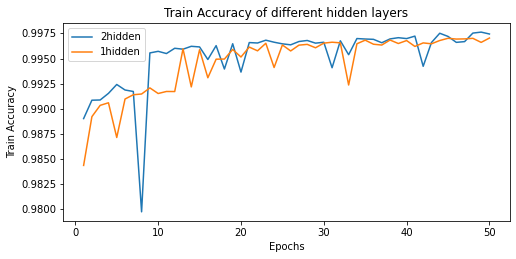

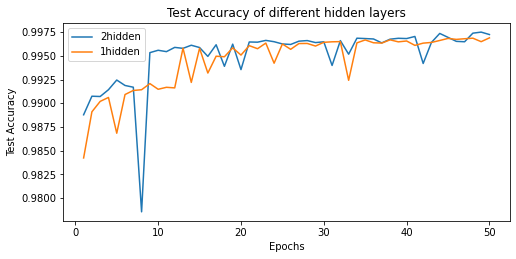

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(epochs[0:50], epochs_train_acc[0:50], label='2hidden')
plt.plot(epochs[0:50], layer_train_acc,label='1hidden')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy of different hidden layers')
plt.legend()
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(epochs[0:50], epochs_test_acc[0:50], label='2hidden')
plt.plot(epochs[0:50], layer_test_acc,label='1hidden')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of different hidden layers')
plt.legend()
plt.show()

When the classifier tends to be stable, there is no significant difference in accuracy between one hiding layer and two hiding layers, and the latter may be better. Considering that FFNN with two hiding layers has a pretty good classification performance, we would not increase the number of hiding layers.

### Number of neurons

We used FFNN with two hidden layers. As for the number of its neurons, one solution is to gradually reduce, and the other is to use the same number of neurons, because this is convenient for parameter optimization, we chose the latter [7].

The number of neurons in the hidden layer is generally between the number of nodes in the input layer and the output layer.

In [21]:
#neuron=list()
#train_acc=list()
#test_acc=list()
#deltaepochs=1
#n=6

#for i in range(0,13) :
#        model = Sequential()
#        model.add(Dense(n, input_dim=78, activation='relu'))
#        model.add(Dense(n, activation='relu'))
#        model.add(Dense(6, activation='softmax'))
#        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#        print("neuron : " + str(n))
#        model.fit(train_x, train_y, epochs=10, batch_size=256)
#        scores = model.evaluate(train_x, train_y)
#        test_scores = model.evaluate(test_x, test_y)
#        neuron.append(n)
#        train_acc.append(scores[1])
#        test_acc.append(test_scores[1])
#        n+=6

#pickle.dump(neuron, open( "neuron.p", "wb" ) )
#pickle.dump(train_acc, open( "neuron_train_acc.p", "wb" ) )
#pickle.dump(test_acc, open( "neuron_test_acc.p", "wb" ) )

In [22]:
neuron_train_acc = pickle.load(open('neuron_train_acc.p','rb'))
neuron_test_acc = pickle.load(open('neuron_test_acc.p','rb'))
neuron = pickle.load(open('neuron.p','rb'))

In [23]:
dic2 = {'neuron':['6', '12', '18', '24', '30', '36', '42', '48', '54', '60', '66', '72', '78']
       ,'train_acc':neuron_train_acc
       ,'test_acc':neuron_test_acc}
pd.DataFrame(dic2)

,neuron,train_acc,test_acc
0,6,0.989983,0.989958
1,12,0.995737,0.995545
2,18,0.991481,0.991394
3,24,0.995653,0.995569
4,30,0.995783,0.995618
5,36,0.993287,0.993246
6,42,0.996118,0.995989
7,48,0.995737,0.995647
8,54,0.994535,0.994499
9,60,0.991830,0.991872


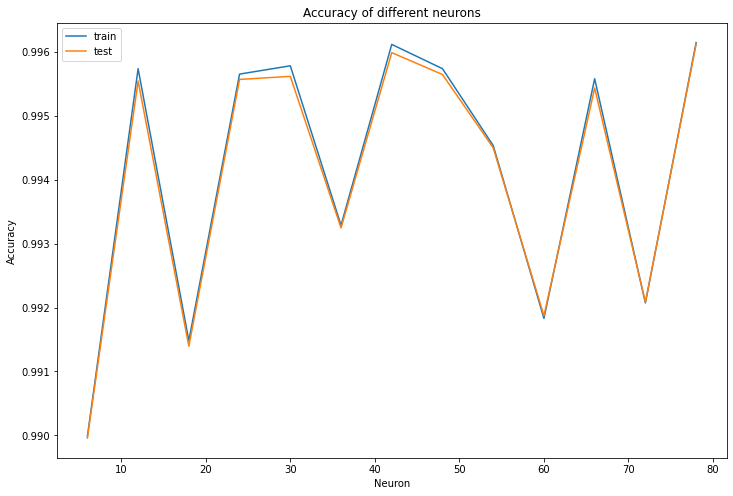

In [24]:
plt.figure(figsize=(12,8))
plt.plot(neuron, neuron_train_acc, label='train')
plt.plot(neuron, neuron_test_acc,label='test')
plt.xlabel('Neuron')
plt.ylabel('Accuracy')
plt.title('Accuracy of different neurons')
plt.legend()

plt.show()

It is difficult to determine the number of nodes in the hidden layer, because there is no clear rule. As can be seen from the figure, the previously chosen 42 is a good choice, and we can also choose 78 as the number of neurons in the hidden layer.

### Learning rate

Learning rate is one of the most important hyperparameters of neural network, it instructs us how to adjust the weight of network by the gradient of loss function. The lower the learning rate, the slower the loss function changes. We started with a small learning rate [8].

In [25]:
#lr=[0.001, 0.01, 0.1, 0.2, 0.3]
#train_acc=list()
#test_acc=list()

#for i in range(0,5) :
#        model = Sequential()
#        model.add(Dense(42, input_dim=78, activation='relu'))
#        model.add(Dense(42, activation='relu'))
#        model.add(Dense(6, activation='softmax'))
#        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=lr[i]), metrics=['accuracy'])
#        print("learning_rate : " + str(lr[i]))
#        model.fit(train_x, train_y, epochs=20, batch_size=256)
#        scores = model.evaluate(train_x, train_y)
#        test_scores = model.evaluate(test_x, test_y)
#        train_acc.append(scores[1])
#        test_acc.append(test_scores[1])

#pickle.dump(train_acc, open( "lr_train_acc.p", "wb" ) )
#pickle.dump(test_acc, open( "lr_test_acc.p", "wb" ) )

In [26]:
lr_train_acc = pickle.load(open('lr_train_acc.p','rb'))
lr_test_acc = pickle.load(open('lr_test_acc.p','rb'))

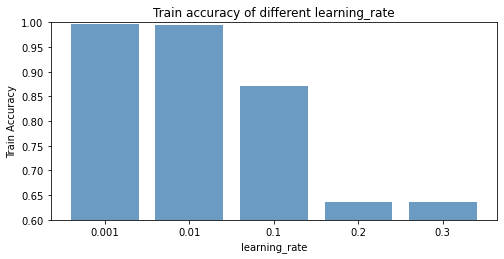

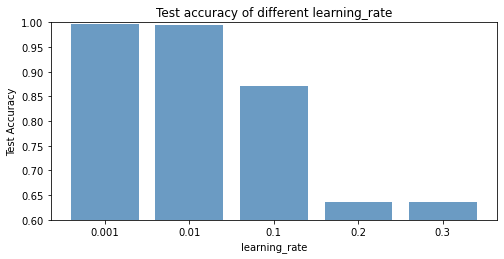

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.bar(range(5), lr_train_acc, align = 'center', color = 'steelblue', alpha = 0.8)
plt.xticks(range(5), ['0.001', '0.01', '0.1', '0.2', '0.3'])
plt.ylim([0.6, 1])
plt.xlabel('learning_rate')
plt.ylabel('Train Accuracy')
plt.title('Train accuracy of different learning_rate')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.bar(range(5), lr_train_acc, align = 'center', color = 'steelblue', alpha = 0.8)
plt.xticks(range(5), ['0.001', '0.01', '0.1', '0.2', '0.3'])
plt.ylim([0.6, 1])
plt.xlabel('learning_rate')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy of different learning_rate')
plt.show()

When the learning rate reaches the magnitude of 0.1, the accuracy drops sharply, so we should choose a smaller learning rate, such as 0.001.

### Dropout

The Dropout layer is used to prevent overfitting by randomly disconnecting the input neurons at a certain rate when each parameter is updated in the training process. It may be at the expense of lower accuracy, so not too many neurons can be broken, and we set the rate to be less than 0.1 [9].

In [28]:
#dropout_rate = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
#train_acc=list()
#test_acc=list()

#for i in range(0,11) :
#        model = Sequential()
#        model.add(Dense(78, input_dim=78, activation='relu'))
#        model.add(Dense(78, activation='relu'))
#        model.add(Dropout(dropout_rate[i]))
#        model.add(Dense(6, activation='softmax'))
#        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#        print("dropout_rate : " + str(dropout_rate[i]))
#        model.fit(train_x, train_y, epochs=25, batch_size=256)
#        scores = model.evaluate(train_x, train_y)
#        test_scores = model.evaluate(test_x, test_y)
#        train_acc.append(scores[1])
#        test_acc.append(test_scores[1])

#pickle.dump(train_acc, open( "dropout_train_acc.p", "wb" ) )
#pickle.dump(test_acc, open( "dropout_test_acc.p", "wb" ) )

In [29]:
dropout_rate = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
dropout_train_acc = pickle.load(open('dropout_train_acc.p','rb'))
dropout_test_acc = pickle.load(open('dropout_test_acc.p','rb'))

In [30]:
dic3 = {'dropout_rate':dropout_rate
       ,'train_acc':dropout_train_acc
       ,'test_acc':dropout_test_acc}
pd.DataFrame(dic3)

,dropout_rate,train_acc,test_acc
0,0.00,0.992849,0.992966
1,0.01,0.996740,0.996476
2,0.02,0.996682,0.996500
3,0.03,0.996419,0.996215
4,0.04,0.996200,0.996037
5,0.05,0.996644,0.996423
6,0.06,0.994318,0.994383
7,0.07,0.996601,0.996394
8,0.08,0.996186,0.996042
9,0.09,0.996845,0.996640


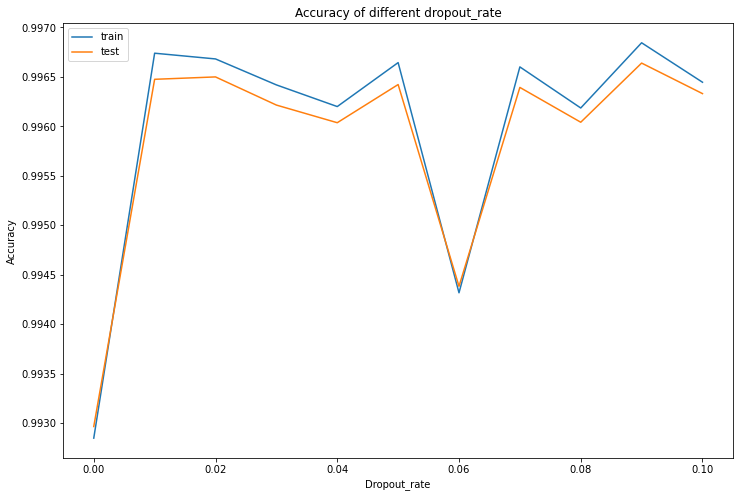

In [31]:
plt.figure(figsize=(12,8))
plt.plot(dropout_rate, dropout_train_acc, label='train')
plt.plot(dropout_rate, dropout_test_acc,label='test')
plt.xlabel('Dropout_rate')
plt.ylabel('Accuracy')
plt.title('Accuracy of different dropout_rate')
plt.legend()

plt.show()

After the dropout layer was added, the performance of FFNN is improved, and then we set the Dropout_rate to 0.01.

## 4. Prediction

In the above work, we have found some appropriate hyperparameters. Although they are explored separately and cannot guarantee that their combination is the best, we can still be sure that these hyperparameters guarantee a better neural network model.

In [32]:
#model = Sequential()
#model.add(Dense(78, input_dim=78, activation='relu'))
#model.add(Dense(78, activation='relu'))
#model.add(Dropout(0.01))
#model.add(Dense(6, activation='softmax'))
#model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
#model.fit(train_x, train_y, epochs=100, batch_size=256)

#pred = model.predict(test_x)
#pred_test_y = pred.argmax(axis=1)

#model.save("pred_model.h5")
#pickle.dump(pred_test_y, open( "pred_test_y.p", "wb" ) )

In [33]:
pred_model = tf.keras.models.load_model('pred_model.h5')
pred_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 78)                6162      
_________________________________________________________________
dense_1 (Dense)              (None, 78)                6162      
_________________________________________________________________
dropout (Dropout)            (None, 78)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 474       
Total params: 12,798
Trainable params: 12,798
Non-trainable params: 0
_________________________________________________________________


In [34]:
pred_test_y = pickle.load(open('pred_test_y.p','rb'))

### visualization

In [35]:
matrix = confusion_matrix(test_y, pred_test_y)

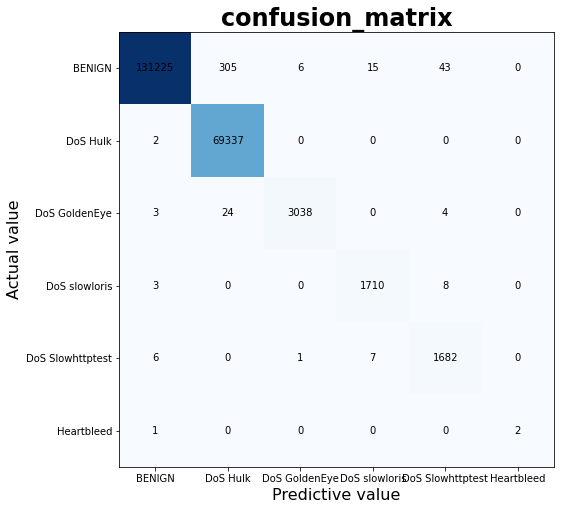

In [36]:
label=np.array(['BENIGN', 'DoS Hulk', 'DoS GoldenEye', 'DoS slowloris', 'DoS Slowhttptest', 'Heartbleed'])

plt.figure(figsize=(8,8))
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(range(6), label)
plt.yticks(range(6), label)
plt.xlabel('Predictive value',fontsize=16)
plt.ylabel('Actual value',fontsize=16)
plt.title('confusion_matrix', fontsize=24, fontweight= 'black')

for i in range(6):
    for j in range(6):
        plt.text(j, i, matrix[i][j],ha="center", va="center")

In [37]:
print(classification_report(test_y, pred_test_y,
                           target_names=['BENIGN', 'DoS Hulk', 'DoS GoldenEye', 'DoS slowloris', 'DoS Slowhttptest', 'Heartbleed']))

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    131594
        DoS Hulk       1.00      1.00      1.00     69339
   DoS GoldenEye       1.00      0.99      0.99      3069
   DoS slowloris       0.99      0.99      0.99      1721
DoS Slowhttptest       0.97      0.99      0.98      1696
      Heartbleed       1.00      0.67      0.80         3

        accuracy                           1.00    207422
       macro avg       0.99      0.94      0.96    207422
    weighted avg       1.00      1.00      1.00    207422



We can see that except for the small sample size of the Heartbleed attack, the prediction and classification effect of other categories is very good, especially the **Dos Hulk** attack, where only two out of 70,000 or so data were incorrectly classified as benign.

## 5. Tensorflow, HPC and more

TensorFlow is a very powerful deep learning tool, and we only use a simple model and functionality right now, which is not enough. It also has many extensions, such as the visualization tool **TensorBoard** and the hyperparameter tuning tool **Kerastuner** [10] .

In this assessment, I only studied each hyperparameter separately, and observed their influence and contribution to the performance of neural network, which is helpful to understand the principle of hyperparameter. But I didn't use grid search, random search or more advanced methods, which is an area that can be improved.

Working on the HPC is also a challenging job. Currently we could install the TensorFlow module and run some simple code, but when I tried to use Kerastuner for hyperparameter tuning, I ran into a big obstacle., we still need to learn and exercise.

## 6. References

[1] [keras guide](https://keras.io/guides/sequential_model/)

[2] [Deep learning methods in network intrusion detection: A survey and an
objective comparison](https://scholar.google.co.uk/scholar?q=deep+learning+methods+in+network+intrusion+detection+a+survey+and+an+objective+comparison&hl=zh-CN&as_sdt=0&as_vis=1&oi=scholart)

[3] [Keras input explanation: input_shape, units, batch_size, dim, etc](https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)

[4] [How to Choose Loss Functions When Training Deep Learning Neural Networks](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

[5] [How to Control the Stability of Training Neural Networks With the Batch Size](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)

[6] [The Number of Hidden Layers](https://www.heatonresearch.com/2017/06/01/hidden-layers.html)

[7] [How to choose the number of hidden layers and nodes in a feedforward neural network?](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

[8] [Setting the learning rate of your neural network](https://www.jeremyjordan.me/nn-learning-rate/)

[9] [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

[10] [keras_tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)